# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [276]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [277]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [279]:
#количество пропусков
data.isnull().sum()
data.isnull().mean() *100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
cityCenters_nearest     23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

In [280]:
data.duplicated().sum() #проверим дубликаты

0

### Вывод
###### Датасет содержит 22 столбца и 23699 строк, во многих строках имеются множественные пропуски, которые придется заполнять разными методами. Некоторые будем заполнять нулями или False, количественные - медианами, а некоторые данные, возможно, получится достать из уже имеющихся.¶
###### Датасет также содержит различные типы данных, которые мы также преобразуем на втором шаге - предобработка данных. Дубликатов в данных нет.

## Предобработка данных

### Обработка выбросов

#### Рассмотрим высоту потолков

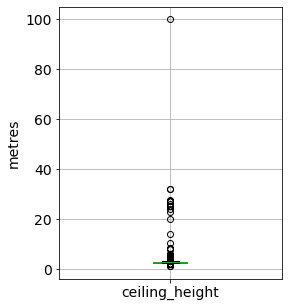

In [281]:
data.boxplot(["ceiling_height"], figsize=(4,5), fontsize=14)
plt.ylabel("metres", fontsize=14)
plt.show()

In [282]:
data[data.ceiling_height > 20].head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0


In [283]:
data['ceiling_height'].sort_values(ascending=False)

22869    100.0
3148      32.0
22336     32.0
21377     27.5
10773     27.0
         ...  
23687      NaN
23690      NaN
23692      NaN
23695      NaN
23696      NaN
Name: ceiling_height, Length: 23699, dtype: float64

Как мы видим единственный выброс это 100 метровый потолок. Исбавимся от него.Остальные значения, где потолок больше 20 это аномальные значения, мы разделим его на 10. 

In [284]:
data = data.drop([22869])

In [285]:
data['ceiling_height'] = data['ceiling_height'].apply( lambda x: x if (x < 20) else x/10 ) # делим значения потолков, которые больше 20 на 10

###### Удалим строки с аномально высокими и низкими потолками

In [286]:
data.drop(data[data.ceiling_height > 3.5].index, inplace=True)
data.drop(data[data.ceiling_height < 2.001].index, inplace=True)

###### Проверим как выглядит boxplot теперь

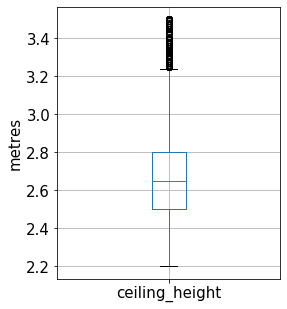

In [287]:
data.boxplot(["ceiling_height"], figsize=(4,5), fontsize=15)
plt.ylabel("metres", fontsize=15)
plt.show()

In [288]:
data.reset_index(inplace=True) #Дадим новые индексы

In [289]:
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [290]:
data.drop(labels='index', axis=1, inplace=True)

In [291]:
print("Среднее по высоте потолков: {:.2f}".format(data.ceiling_height.mean()))
print("Медиана по высоте потолков: {:.2f}".format(data.ceiling_height.median()))

Среднее по высоте потолков: 2.70
Медиана по высоте потолков: 2.65


#### Цена объекта

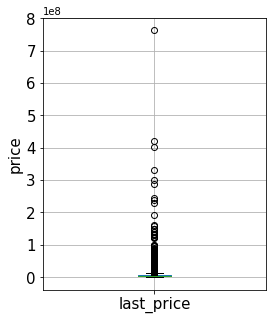

count    2.340200e+04
mean     6.355715e+06
std      1.035309e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [292]:
data.boxplot(["last_price"], figsize=(4,5), fontsize=15)
plt.ylabel("price", fontsize=15)
plt.show()
data['last_price'].describe()

In [293]:
print("Медианная стоимость квартиры : {:.0f}".format(data['last_price'].median()))
print("Средняя стоимость квартиры : {:.0f}".format(data['last_price'].mean()))
print("Количество квартир стоимостью более 20 млн. : {}".format(data[data.last_price > 20000000]['last_price'].count()))
print("Количество квартир стоимостью менее 500 тыс. : {}".format(data[data.last_price < 500000]['last_price'].count()))

Медианная стоимость квартиры : 4600000
Средняя стоимость квартиры : 6355715
Количество квартир стоимостью более 20 млн. : 639
Количество квартир стоимостью менее 500 тыс. : 14


###### В нашей выборке очень мало квартир дороже 20 млн и дешевле 500 тыс. Избавимся от аномальных наблюдений

In [294]:
data.drop(data[data.last_price > 20000000].index, inplace=True)
data.drop(data[data.last_price < 500000].index, inplace=True)

#### Общая площадь

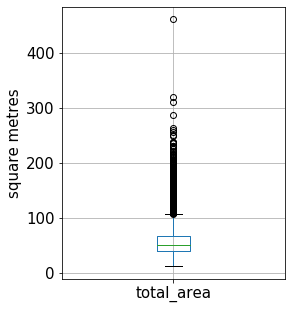

count    22749.000000
mean        56.424877
std         24.396864
min         12.000000
25%         39.900000
50%         51.000000
75%         67.000000
max        460.800000
Name: total_area, dtype: float64

In [295]:
data.boxplot(["total_area"], figsize=(4,5), fontsize=15)
plt.ylabel("square metres", fontsize=15)
plt.show()
data['total_area'].describe()

In [296]:
print("Медианная площадь квартиры : {:.0f}".format(data['total_area'].median()))
print("Средняя площадь квартиры : {:.0f}".format(data['total_area'].mean()))
print("Количество квартир площадью более 120 кв. м. : {}".format(data[data.total_area > 120]['total_area'].count()))
print("Количество квартир площадью менее 15 кв.м. : {}".format(data[data.total_area < 15]['total_area'].count()))

Медианная площадь квартиры : 51
Средняя площадь квартиры : 56
Количество квартир площадью более 120 кв. м. : 483
Количество квартир площадью менее 15 кв.м. : 6


###### Избавимся от аномальных значений

In [297]:
data.drop(data[data.total_area > 120].index, inplace=True)
data.drop(data[data.total_area < 15].index, inplace=True)

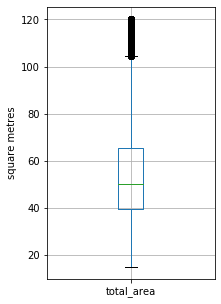

count    22260.000000
mean        54.387649
std         19.627693
min         15.000000
25%         39.300000
50%         50.000000
75%         65.300000
max        120.000000
Name: total_area, dtype: float64

In [298]:
data.boxplot(["total_area"], figsize=(3,5), fontsize=10)
plt.ylabel("square metres", fontsize=10)
plt.show()
data['total_area'].describe()

### Заполнение пропусков

###### Пропуски в столбцах:

In [299]:
data.isna().sum()
data.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.394789
floors_total            0.003684
living_area             0.078347
floor                   0.000000
is_apartment            0.883872
studio                  0.000000
open_plan               0.000000
kitchen_area            0.095912
balcony                 0.480144
locality_name           0.001977
airports_nearest        0.245418
cityCenters_nearest     0.244654
parks_around3000        0.244609
parks_nearest           0.679335
ponds_around3000        0.244609
ponds_nearest           0.633423
days_exposition         0.126595
dtype: float64

#### Стратегия заполнения пропусков
###### 1) floors_total - по возможности заполним пропуски уже имеющимися данными по тому же дому из датасета (предположим, что каждый дом однозначно определяется расстоянием до аэропорта и центра города), оставшиеся пропуски заполним медианными значениями      
###### 2) ceiling_height - попробуем определить высоту потолков по существующим домам, оставшиеся пропуски оставим незаполненными living_area , kitchen_area - заполним медианой
###### 3) is_apartment - заполним пропуски значениями False
###### 4) balcony - пропущенные значения заменим на 0
###### 5) locality_name - на пустую строку " "
###### 6) airports_nearest , cityCenters_nearest , parks_nearest , ponds_nearest , days_exposition - оставим пропущенные значения как они есть, чтобы не исказить статистики и в будущем иметь возможность работать с ними как с числовыми столбцами. Заполнять пропуски в данных столбцах не будем
###### 7) ponds_around3000 , parks_around3000 - заполним нулями

#### Заполним пропущенные значения этажности

In [300]:
print("Пропущенных значений этажности дома:", data.floors_total.isna().sum())

Пропущенных значений этажности дома: 82


###### Создадим для этого сводную таблицу, где индексами будет выступать расстояние до центра, а столбцами - расстояния до аэропорта

In [301]:
floors_pivot = data.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='floors_total', aggfunc='first')

###### Используем цикл, пробегающий по датафрейму, в котором пропущены значения этажности дома

In [302]:
for index, row in data[data.ceiling_height.isna()].iterrows():
    try:
        cell = floors_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            data.loc[index, 'floors_total'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        pass # В случае если такого дома не существует
print("Пропусков:", data.floors_total.isna().sum())

Пропусков: 30


###### Оставшиеся 33 пропуска этажности заполним средними значениями, не получилось заменить те значения, где нет подобного сочетания расстояний, т.е. дом не существует. Большую часть значений удалось заменить, значит многие дома встречаются как минимум дважды

In [303]:
data.floors_total.fillna(value=data['floors_total'].mean(), inplace=True)
print("Пропусков этажности:", data.floors_total.isna().sum())

Пропусков этажности: 0


#### Заполним пропущенные значения высоты потолков

In [304]:
ceilings_pivot = data.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='ceiling_height', aggfunc='first')

In [305]:
for index, row in data[data.ceiling_height.isna()].iterrows() :
    
    try:
        cell = ceilings_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            data.loc[index, 'ceiling_height'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        pass # В случае если такого дома не существует
print("Количество пропусков в столбце высоты потолков:", data.ceiling_height.isna().sum())
print(f"Таким способом нам удалось устранить {9150 - data.ceiling_height.isna().sum()} пропуска точно правильными значениями" )

Количество пропусков в столбце высоты потолков: 5328
Таким способом нам удалось устранить 3822 пропуска точно правильными значениями


#### Заполним оставшиеся пропуски

In [306]:
data.fillna( 
    value =     
                {
                 'living_area' : data['living_area'].median(),   # Заполним пропуски в столбце жилой и кухонной
                 'kitchen_area' : data['kitchen_area'].median(), # площади на медианное значение
                 'is_apartment' : False,                       # Заполним пропуски на False в столбце is_apartment
                 'balcony' : 0,                             
                 'parks_around3000' : 0,
                 'ponds_around3000' : 0,
                 'locality_name' : " ",                        # Заполним пропущенные значения locality_name на пустую строку
                 }, 
          
                  inplace=True )

#### Обработаем столбец с временем

In [307]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.first_day_exposition.head(3)

0   2019-03-07
1   2018-12-04
2   2015-08-20
Name: first_day_exposition, dtype: datetime64[ns]

#### Преобразуем типы данных

In [308]:
data['last_price'] = data['last_price'].astype(int)
data['floors_total'] = data['floors_total'].astype(int)
data['balcony'] = data['balcony'].astype(int)

In [309]:
# data[(data.rooms == 0) & (data.studio == False)]['total_area'].value_counts().sort_index().tail(10)
# Рассмотрим квартиры с нулевым количество комнат и не студии

In [310]:
#Скорее всего это пропуски при заполнении данных, заменим количество комнат для квартир площадью менее 45 кв.м. на 1, для тех у которых меньше 100 кв.м. на 2, для остальных - на 5 

#### Расмотрим квартиры с нулевым значением комнат и не являющиеся студиями:

In [311]:
data[(data.rooms == 0) & (data.studio == False)]['total_area'].value_counts().sum()

58

удалим строки

In [312]:
data.drop(data[(data.rooms == 0) & (data.studio == False)].index, inplace=True)

###### Вывод

На данном этапе мы очистили данные от выбросов.
Произвели различные замены пропущенных значений.
Для многих квартир отсутствовали значения total_floors или ceiling_height - многие из них нам удалось восстановить из имеющихся данных, поскольку дома в датасете повторяются.
Некоторые пропущенные значения оставили незаполненными для того, чтобы избежать искажения статистики, а также с NaN удобно проводить вычисления, так как это тип float
Количественные параметры: living_area , kitchen_area были заменены на медианные.
Также преобразованы типы данных: из строковых в формат даты, из чисел с плавающей точкой в целочисленный.
Квартиры с нулевым количеством комнат были удалены из датафрейма.

## Расчёты и добавление результатов в таблицу


### Добавим цену за кв. метр. в таблицу

In [313]:
data['price_for_square_meter'] = data['last_price'] / data['total_area']

###  Добавим столбцы с днем недели, месяцем и годом

In [314]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

### Столбец с этажом: первый, последний, другой

In [315]:
def flat_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [316]:
data['floor_category'] = data.apply(flat_floor, axis=1)

In [317]:
data.floor_category.value_counts()

другой       16383
последний     3021
первый        2798
Name: floor_category, dtype: int64

###  Добавим отношение жилой площади к общей

In [318]:
data['living_to_total'] = data['living_area'] / data['total_area']

### Добавим отношение площади кухни к общей

In [319]:
data['kitchen_to_total'] = data['kitchen_area'] / data['total_area']
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_for_square_meter,weekday,month,year,floor_category,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,NaN,12,14.4,5,False,...,0.0,NaN,55.0,95065.789474,0,9,2018,другой,0.473684,0.299342


## Исследовательский анализ данных


###  Построим гистограммы распределения Общей площади , Цены , Комнат , Высоты потолков

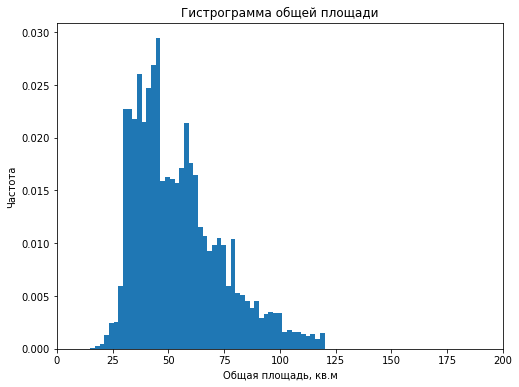

In [320]:
data.plot(y='total_area', kind='hist', density=True, bins=50, xlim=(0,200), figsize=(8,6),  title='Гистрограмма общей площади', legend=None)
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Частота')
plt.show()

###### График показывает, что квартиры от 25 кв.м до 60 кв.м пользуется популярностью

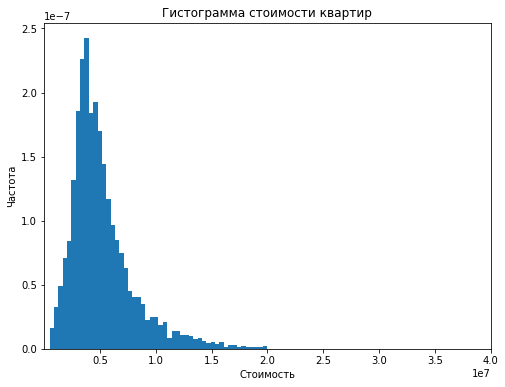

In [321]:
data.plot(y='last_price', kind='hist', density=True, bins=50, xlim=(12190,40000000), figsize=(8,6), title='Гистограмма стоимости квартир', legend=None)
plt.xlabel('Стоимость')
plt.ylabel('Частота')
plt.show()

###### с данными все впорядке, но значения выводятся в экспоненциальной записи чисел

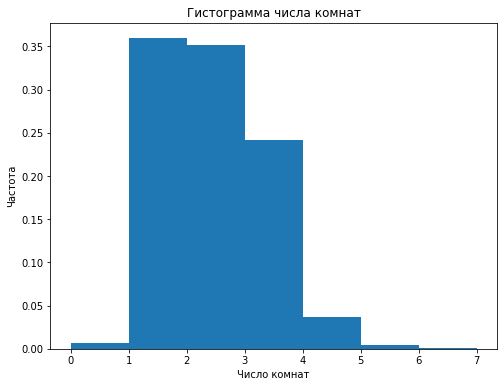

In [322]:
data.plot(y='rooms', kind='hist', density=True, bins=7, range=(0, 7), figsize=(8,6), title='Гистограмма числа комнат', legend=None)
plt.xlabel('Число комнат')
plt.ylabel('Частота')
plt.show()

###### по графику видим, что однокомнатные и двухкомнатные квартиры имеют большую популярность

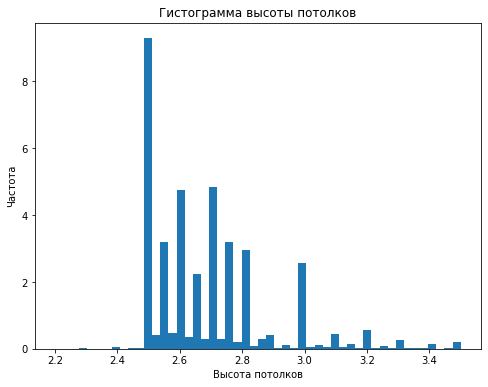

In [323]:
data.plot(y='ceiling_height', kind='hist', bins=50, range=(2.2, 3.5), density=True, figsize=(8,6), title='Гистограмма высоты потолков', legend=None)
plt.xlabel('Высота потолков')
plt.ylabel('Частота')
plt.show()

###### По графику видим, что высота потолков от 2.5 до 3 метров преобладает в городе

In [324]:
data['total_area'].median()

50.1

In [325]:
data['last_price'].median()

4500000.0

In [326]:
data['ceiling_height'].median()

2.65

###### Вывод
Медианное значение площади - 50 кв.м., распределение имеет вид Пуассоновского с пиком около 40 кв.м.
Медианная стоимость квартиры составляет 4.5 млн.
Наибольшее количество квартир однокомнатные, хотя двухкомнатных всего лишь немногим меньше.
Высота потолков составляет 2.65 метра.

### Рассмотрим распределение времени продаж

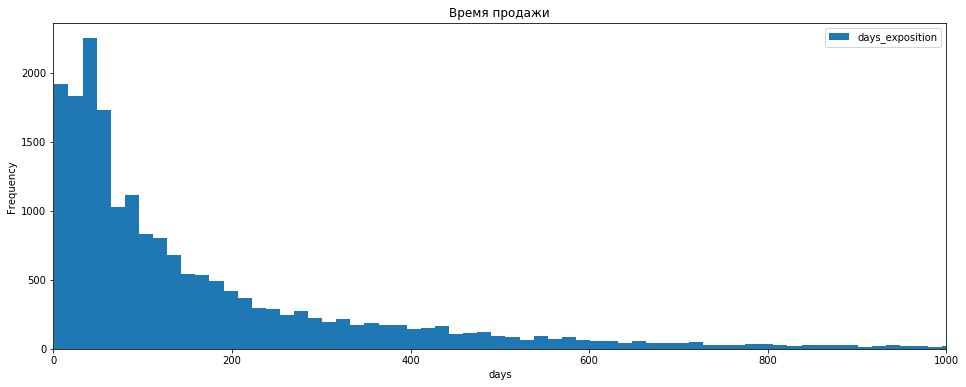

In [327]:
data.plot(y='days_exposition', kind='hist', bins=100, figsize=(16,6), xlim=(0,1000), title='Время продажи')
plt.xlabel("days")
plt.show()

In [328]:
print("Медианное значение времени, требующееся на продажу квартиры: {:.0f}".format(data.days_exposition.median() ))
print("Среднее значение времени на продажу квартиры: {:.1f}".format(data.days_exposition.mean() ))

Медианное значение времени, требующееся на продажу квартиры: 93
Среднее значение времени на продажу квартиры: 175.3


###### среднее значение слишком аномальное, присутсвуют выбросы

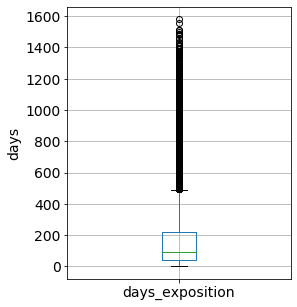

In [329]:
data.boxplot(["days_exposition"], figsize=(4,5), fontsize=14)
plt.ylabel("days", fontsize=14)
plt.show()

###### Избавимся от аномальных значений. Будем считать продажу быстрой, если она уложилась в неделю, и медленной, если она длилась более полутора лет¶

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<h2> Комментарий ревьюера</h2>
    
Согласна. </div>

In [330]:
good_exposition_data = data.query('7<days_exposition<550')['days_exposition'] # избавляемся от выбросов и аномальных 
                                                                              # по скорости продаж
good_exposition_data = good_exposition_data.astype(int)

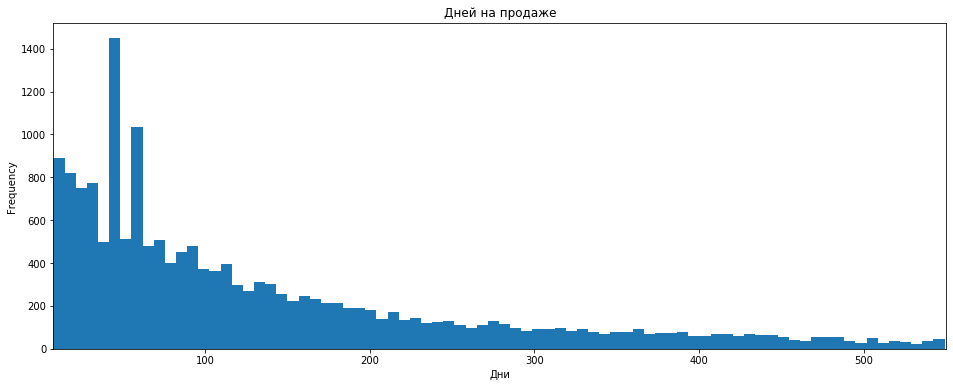

In [331]:
good_exposition_data.plot(kind='hist', bins=80, xlim=(8,550), figsize=(16,6))
plt.xlabel("Дни")
plt.title("Дней на продаже")
plt.show()

In [332]:
good_exposition_data.value_counts().head(4)

45    861
60    532
30    200
90    156
Name: days_exposition, dtype: int64

###### Значения 45, 60, 30, 90 - самые популярные и явно отличаются от других в большую сторону

In [333]:
print(f"Мединное значение времени продажи - порядка {good_exposition_data.median()} дней")

Мединное значение времени продажи - порядка 90.0 дней


### Посмотрим, как стоимость Квартиры зависит от площади , числа комнат , удалённости от центра

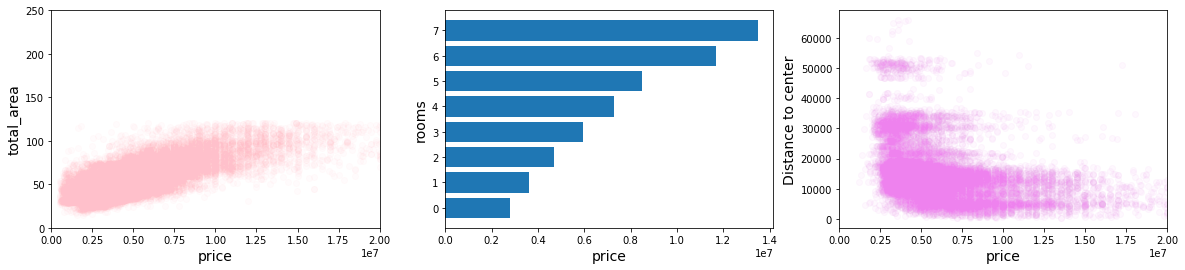

In [334]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))

ax1.scatter(data['last_price'], data['total_area'], c='pink', alpha=0.05)
ax1.set_xlim([0,20000000])
ax1.set_ylim([0,250])
ax1.set_ylabel('total_area', fontsize=14)
ax1.set_xlabel('price', fontsize=14)

rooms_price = data[['rooms', 'last_price']].groupby(['rooms']).median()
ax2.barh( rooms_price.index, rooms_price['last_price'])
ax2.set_ylabel('rooms', fontsize=14)
ax2.set_xlabel('price', fontsize=14)
y_pos = np.arange(0,8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([str(i) for i in range(0,8)])

ax3.scatter(data['last_price'], data['cityCenters_nearest'], c='violet', alpha=0.05)
ax3.set_xlim([0,20000000])
ax3.set_ylabel('Distance to center', fontsize=14)
ax3.set_xlabel('price', fontsize=14)

plt.show()

In [335]:
data[['last_price','total_area','cityCenters_nearest','rooms']].corr()

,last_price,total_area,cityCenters_nearest,rooms
last_price,1.000000,0.735474,-0.346756,0.439876
total_area,0.735474,1.000000,-0.171292,0.793398
cityCenters_nearest,-0.346756,-0.171292,1.000000,-0.103201
rooms,0.439876,0.793398,-0.103201,1.000000


###### На графике зависимости стоимости квартиры от общей площади явно видна положительная корреляция.
###### На столбчатой диаграмме также заметна увеличивающаяся стоимость квартиры с увеличением числа комнат.
###### На графике зависимости стоимости квартиры от расстояния до центра города также видна зависимость, предположительно - гиперболическая. Чем дальше квартира - тем дешевле она стоит

### Рассмотрим как зависит стоимость квартиры от этажа

In [336]:
floor_price = data[['floor_category', 'last_price']].groupby(['floor_category']).median().sort_values('last_price')

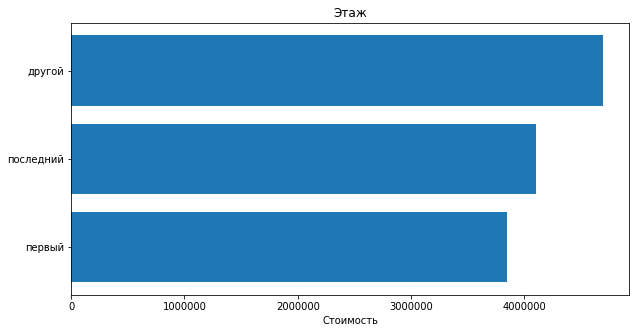

In [337]:
plt.figure(figsize=(10,5))
plt.barh( floor_price.index, floor_price['last_price'])
plt.title("Этаж")
plt.xlabel("Стоимость")
plt.show()

###### Как мы видим, квартиры на 1 этаже стоят гораздо дешевле других. На последнем ненамного дороже, тех кто на первом.

### Рассмотрим как зависит стоимость квартиры от даты размещения: дня недели, месяца и года.

In [338]:
year_price = data[['year', 'last_price']].groupby(['year']).median().sort_values('last_price')

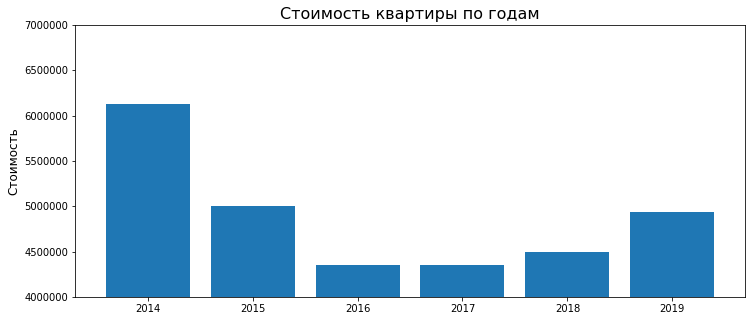

In [339]:
plt.figure(figsize=(12,5))
plt.bar( year_price.index, year_price['last_price'])
plt.title("Стоимость квартиры по годам", fontsize=16)
plt.ylabel("Стоимость", fontsize=12)
plt.ylim(4000000, 7000000)
plt.show()

###### Как мы видим по графику, в 2014 году квартиры были самыми дорогими, дальше рынок снижался и постепенный рост стал наблюдаться к 2018-2019 году.

In [340]:
month_price = data[['month', 'last_price']].groupby(['month']).median().sort_index()
month_price.index = ['январь', 'февраль', 'март', "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]

###### Месяц

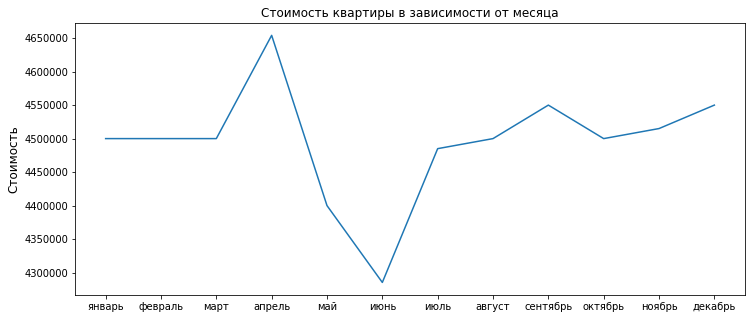

In [341]:
plt.figure(figsize=(12,5))
plt.plot( month_price.index, month_price['last_price'])
plt.title("Стоимость квартиры в зависимости от месяца")
plt.ylabel("Стоимость", fontsize=12)
plt.show()

###### Как мы видим, в июне квартиры продаются дешевле остальных. В апреле наблюдается максимальный рост по цене

###### День

In [342]:
day_price = data[['weekday', 'last_price']].groupby(['weekday']).median().sort_index()
day_price.index = ['понедельник', 'вторник', 'среда', "четверг", "пятница", "суббота", "воскресенье"]

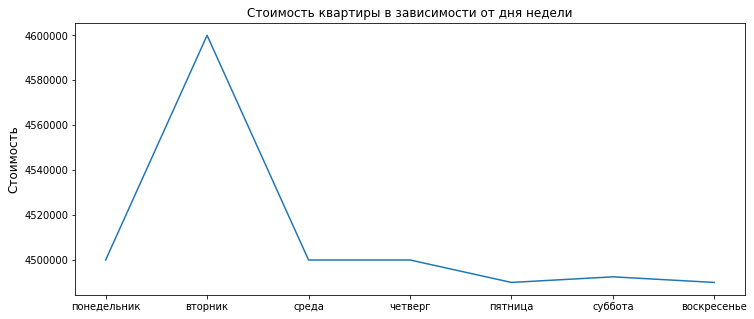

In [343]:
plt.figure(figsize=(12,5))
plt.plot( day_price.index, day_price['last_price'])
plt.ylabel("Стоимость", fontsize=12)
plt.title("Стоимость квартиры в зависимости от дня недели")
plt.show()

###### График показывает, что на вторник присутствует пик по цене. В выходные обычно продаются дешевле

### 10 населенных пунктов с самой высокой стоимостью кв. метра

In [344]:
top_locals = data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10).index.values.tolist()

In [345]:
data_filtered = data.query('locality_name in @top_locals')

In [346]:
data_filtered.groupby('locality_name')['price_for_square_meter'].mean().sort_values(ascending=False)

locality_name
Санкт-Петербург      108645.684395
Пушкин               101913.956187
деревня Кудрово       92312.310411
посёлок Парголово     90348.996281
посёлок Мурино        85563.326907
посёлок Шушары        78643.827638
Колпино               75370.025473
Гатчина               68974.051834
Всеволожск            67173.646003
Выборг                58336.368985
Name: price_for_square_meter, dtype: float64

###### Самые дорогие квартиры расположены, в Санкт-Петербурге
###### В Гатчине и Всеволжске квартиры стоят одинаково
###### В Выборге квартиры стоят дешевле всего.

### Стоимость квартир в центре

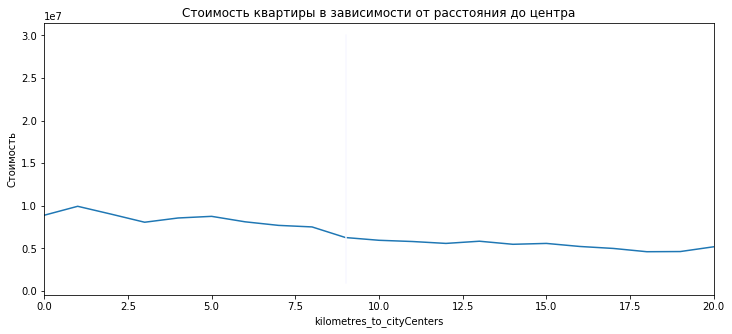

In [347]:
data['kilometres_to_cityCenters'] =( data['cityCenters_nearest']/1000 ).round()
plt.figure(figsize=(12,5))
data.groupby('kilometres_to_cityCenters')['last_price'].mean().plot()
plt.plot([9,9],[1000000,30000000],color='ghostwhite')
plt.xlim(0,20)
plt.title("Стоимость квартиры в зависимости от расстояния до центра")
plt.ylabel("Стоимость")
plt.show()

###### Видим, что цена начинает увеличиваться после 3 км, это объсняется, тем что затрагиваются дорогие районы с красивым видом, но это не будет являться центром города. До 3 км будет считать границей центра города

### Анализ квартир в центре

In [348]:
data_flats_in_center = data.query('kilometres_to_cityCenters <= 3 and locality_name == "Санкт-Петербург"')

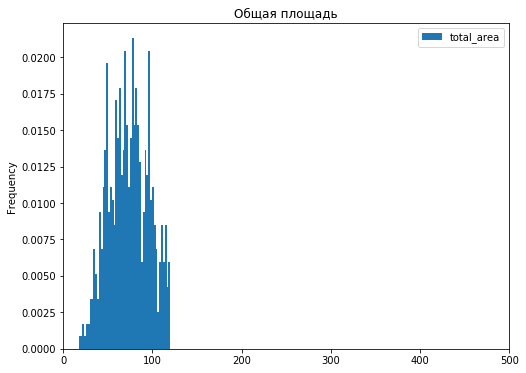

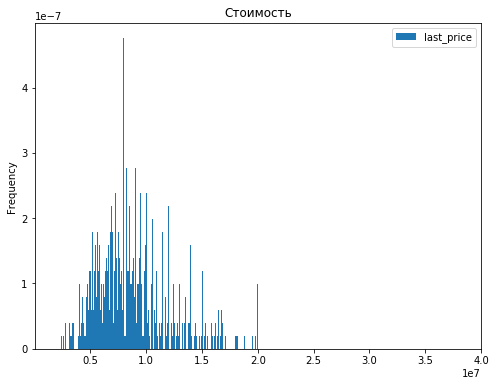

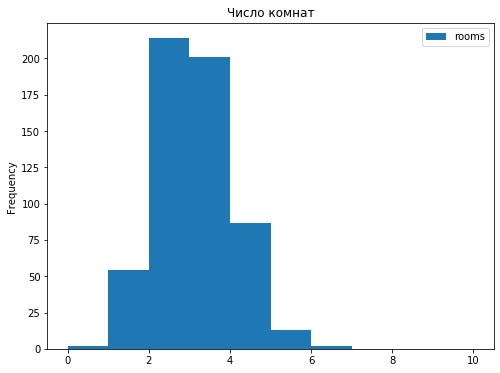

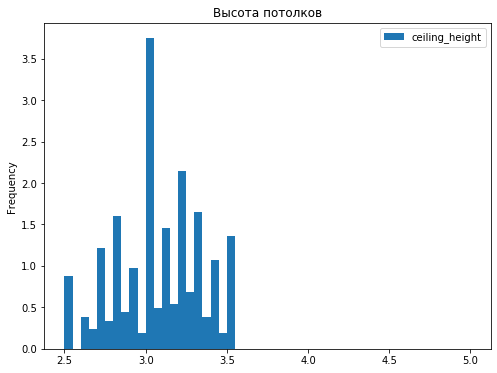

In [349]:
data_flats_in_center.plot(y='total_area', kind='hist', density=True, bins=50, xlim=(0,500), figsize=(8,6), title='Общая площадь')
data_flats_in_center.plot(y='last_price', kind='hist', density=True, bins=200, xlim=(12190,40000000.0), figsize=(8,6), title='Стоимость')
data_flats_in_center.plot(y='rooms', kind='hist', bins=10, range=(0, 10), figsize=(8,6), title='Число комнат')
data_flats_in_center.plot(y='ceiling_height', kind='hist', bins=50, range=(2.5, 5), density=True, figsize=(8,6), title='Высота потолков')
plt.show()

In [350]:
print("Медианное значение площади", data_flats_in_center['total_area'].median())

Медианное значение площади 73.0


In [351]:
print("Медианное значение цены", data_flats_in_center['last_price'].median())

Медианное значение цены 8250000.0


In [352]:
print("Медианное значение высоты потолков", data_flats_in_center.ceiling_height.median())

Медианное значение высоты потолков 3.04


###### В квартирах центре наблюдается большая площадь в размере 73 квадратов
###### Квартиры в центре города более дорогие, чем обычно. Медианная цена состовляет 8 млн, хотя для остальных это 4.5 млн. Цена завышена почти в 2 раза.
###### В квартирах в центре города наблюдаются высокие потолки 3 метра

### Выясним какие факторы влияют на стоимость квартиры в центре (число комнат, этаж, удалённость от центра, дата размещения объявления) и сравним с выводом по всем квартирам

###### Число комнат

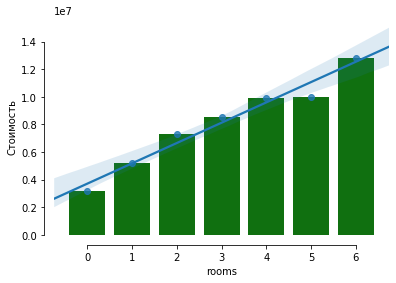

In [353]:
rooms_price_center = data_flats_in_center[['rooms', 'last_price']].groupby(['rooms']).median()
ax = sns.barplot(x=rooms_price_center.index, y=rooms_price_center['last_price'] , color='green' )
# put bars in background:
for c in ax.patches:
    c.set_zorder(0)
# plot regplot with numbers 0,..,len(a) as x value
sns.regplot(x=np.arange(0,len(rooms_price_center)), y=rooms_price_center['last_price'], ax=ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel("Стоимость")
plt.show()

###### Стоимость квартир увеличивается в зависимости от комнат.

###### Этаж

In [354]:
floor_price_center = data_flats_in_center[['floor_category', 'last_price']].groupby('floor_category').median().sort_values('last_price')

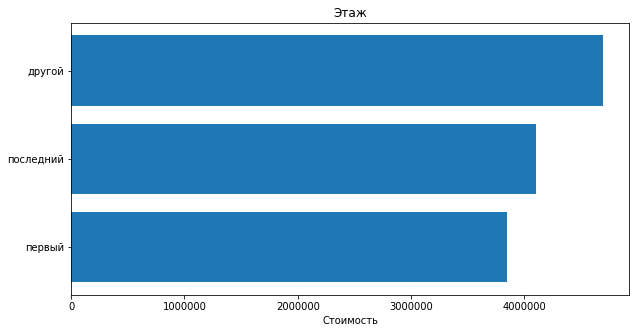

In [355]:
plt.figure(figsize=(10,5))
plt.barh( floor_price.index, floor_price['last_price'])
plt.title("Этаж")
plt.xlabel("Стоимость")
plt.show()

###### Квартиры на первом этаже в центре стоят, так же дешевле, как и во всем датасете

###### Удаленность

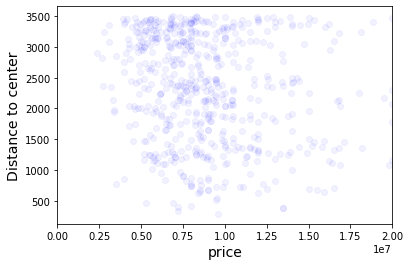

In [356]:
plt.scatter(data_flats_in_center['last_price'], data_flats_in_center['cityCenters_nearest'], c='b', alpha=0.05)
plt.xlim([0,20000000])
plt.xlabel('price', fontsize=14)
plt.ylabel('Distance to center', fontsize=14)
plt.show()

In [357]:
data_flats_in_center[['last_price','cityCenters_nearest']].corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.175769
cityCenters_nearest,-0.175769,1.000000


###### Зависимости не наблюдается, квартиры в центре могут стоить по разному

### Рассмотрим зависимость от даты

###### Год

In [358]:
year_price_center = data_flats_in_center[['year', 'last_price']].groupby(['year']).median().sort_index()

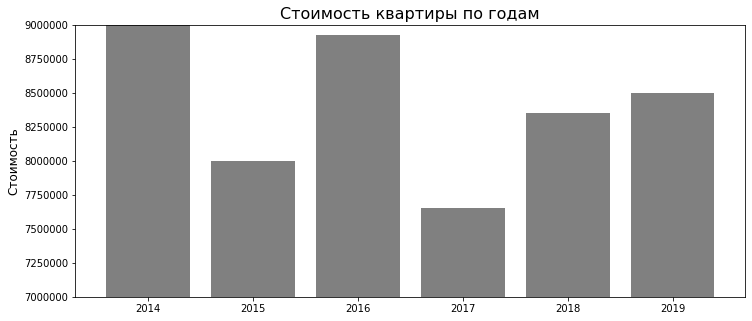

In [359]:
plt.figure(figsize=(12,5))
plt.bar( year_price_center.index, year_price_center['last_price'], color='gray' )
plt.title("Стоимость квартиры по годам", fontsize=16)
plt.ylabel("Стоимость", fontsize=12)
plt.ylim(7000000,9000000)
plt.show()

###### Диаграмма такая же, как и для всей выборки. С 2014 года произошло падение и с 2017 начинало расти

###### месяц

In [360]:
month_price_center = data_flats_in_center[['month', 'last_price']].groupby(['month']).median().sort_index()
month_price_center.index = ['январь', 'февраль', 'март', "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]

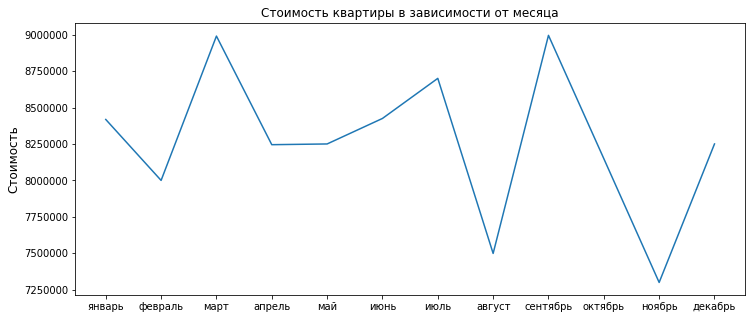

In [361]:
plt.figure(figsize=(12,5))
plt.plot( month_price_center.index, month_price_center['last_price'])
plt.title("Стоимость квартиры в зависимости от месяца")
plt.ylabel("Стоимость", fontsize=12)
plt.show()

###### По графику видно, что квартиры в центре Санкт-петербурга в сентябре дороже всего. Возмодно связано, с началом учебного/рабочего времени.
###### В декабре наоборот, квартиры дешевле пошлых месяцев.

In [362]:
day_price_center = data_flats_in_center[['weekday', 'last_price']].groupby(['weekday']).median().sort_index()
day_price_center.index = ['понедельник', 'вторник', 'среда', "четверг", "пятница", "суббота", "воскресенье"]

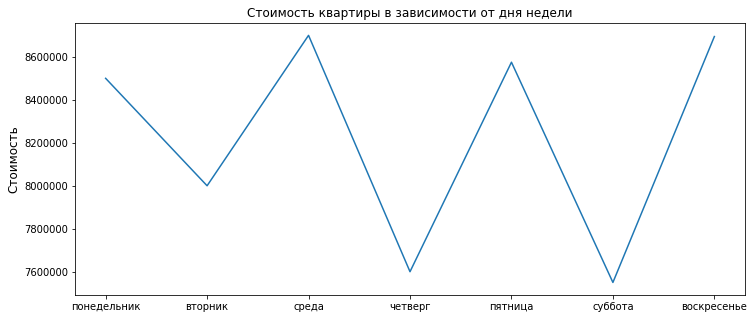

In [363]:
plt.figure(figsize=(12,5))
plt.plot( day_price_center.index, day_price_center['last_price'])
plt.ylabel("Стоимость", fontsize=12)
plt.title("Стоимость квартиры в зависимости от дня недели")
plt.show()

###### Зависимость квартир по дням так же различается, дешевле всего квартиры выставляются в четверг. Дороже всего в воскресенье

## Общий вывод

###### 1) На первом шаге при знакомстве с датасетом были обнаружены множественные пропуски, а также много аномалий, от которых мы в последствии успешно избавились.
###### 2. На втором этапе для пропущенных значений этажности и высоты потолков домов были восстановлены значения по доступным данным из датасета. Заполнены другие пропущенные значения. Изменены типы данных, обработаны выбросы и аномальные значения.
###### 3. На третьем шаге были посчитаны и добавлены в таблицу:
1. Цена квадратного метра;
2. День недели, месяц и год публикации объявления;
3. Этаж квартиры; варианты — первый, последний, другой;
4. Соотношение жилой и общей площади, а также отношение площади кухни к общей.
4. На четвертом этапе был произведен исследовательский анализ данных и было выявлено, что:
1. В среднем квартира продается около трех месяцев
2. Стоимость квартиры прямопропорционально зависит от площади и количества комнат и обратно пропорциональна расстоянию до центра
3. На первом этаже квартиры стоят дешевле
4. Стоимость квартир с 2014 по 2017 снизилась более чем на 2,5 млн. руб.
5. В июне квартиры продаются по самой низкой стоимости, а в апреле по самой высокой
6. Квартира выставленная на продажу в воскресенье в среднем продается на 200 тыс. дешевле чем в пик - во вторник
7. Самые дорогие квартиры находятся в Санкт-Петербурге и Пушкине, а самые дешевые в Выборге
8. Граница центра - 3 километров
9. Медианное значение площади квартир в центре 73 кв.м, а по всей выборки 51 кв.м. В центре намного больше квартиры
10. Медианное значение цена квартир в центре 8 млн 250 тыс, а по всей выборке 4 млн 600 тыс. Почти в 2 раза дороже квартиры в центре.
11. Медианное значение высоты потолков в центре 3 метра, а по всей выборке 2.65. В центре немного повыше потолки, чем по всей выборке.
12. Квартиры в центре сильно отличаются в цене, они примерно в два раза дороже. Площадь квартир больше в среднем на 15 кв.м. Чаще встречаются двух- и трехкомнатные квартиры, нежели однокомнатные. Более высокие потолки - 3 метра, для остальных квартир из датасета - 2,65. 
13. Стоимость квартир в центре также зависит от количества комнат, от этажа (на первом - дешевле), а от удаленности цена квартиры не зависит, в отличие от квартир из всей выборки.
14. Стоимость квартир в центре Санкт-Петербурга также упала с 2014 года.
15. По самой дешевой цене квартиры продаются в декабре, по самой дорогой - в сентябре
16. Квартиры, размещаемые на продажу по четвергам продаются дешевле, чем в остальные дни. Пик стоимости приходится на воскресенье